# Eyes in the Sky: Predicting Aircraft Damage Caused by Bird Strikes Using Machine Learning
## Part 3: Neural Networks

Alan da Silveira Fleck
<br>
alansfleck@gmail.com
<br>
27/09/2021

# Introduction 

An Artificial Neural Network, or simply Neural Network, is a collection of connected units or nodes called artificial neurons, which loosely model the neurons in a biological brain [1]. It is divided into multiple layers that can be grouped into three categories:
- **Input Layer**: This layer represents the underlying features of our independent variable. The number of input units corresponds to the number of features in our data.
- **Hidden Layer**: The hidden layer(s) transform the input features into a format that is useful for classifying the data. The more hidden layers, and the more units in each layer, the more powerful the overall model is.
- **Output Layer**: This layer represents the output choice of the model. For a classification task, which is the case here, we have one unit per class, where each neuron represents a possible class [2].

The objective of Part 3 of this project is to build a neural network to predict damaging  bird strikes on airplanes. This notebook is a natural extension to Part 2, and the results of the advanced model built here will be compared to the results of the models from the previous notebook.

## Importing Packages and Reading the Data

The codes below import the relevant packages and read the cleaned data from Part 1 into a data frame.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score,recall_score,precision_score,f1_score, roc_auc_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

# Import tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
# Reading the csv file into a data frame
cleaned_df = pd.read_csv('data/cleaned_df.csv')

# This will show all columns when calling df.head()
pd.set_option("display.max_columns", None)

# Checking the first 5 rows of the dataset
cleaned_df.head()

,is_airplane,is_more_1000ft,number_struck,is_damaged,number_engines,is_precipitation,wildlife_size,conditions_sky,is_pilot_warned,is_aircraft_large,Year,Month,Weekday,flight_phase_Approach,flight_phase_Climb,flight_phase_Descent,flight_phase_Landing Roll,flight_phase_Parked,flight_phase_Take-off run,flight_phase_Taxi,regions_Canada,regions_International,regions_Region_1,regions_Region_10,regions_Region_2,regions_Region_3,regions_Region_4,regions_Region_5,regions_Region_6,regions_Region_7,regions_Region_8,regions_Region_9
0,1,1,3,1,2,0,1,0,0,1,2000,11,4,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1,0,3,1,2,0,0,1,1,0,2001,7,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1,0,3,0,2,0,0,0,0,0,2001,9,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1,0,3,0,2,0,0,1,1,1,2002,9,4,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,1,0,3,0,2,0,0,0,0,0,2003,6,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


## Train-Test Split and Scalling

Next, we will separate our data into the target (i.e. `is_damaged`) and the features, as well as split the data into train and test sets. We will use a test size of 30% as well as `stratify = y` in order to keep the same proportion of target classes in both sets. 
<br>
<br>
In addition, like in Part 2, the data will be balanced (in this case upsampling class 1) and scaled using the Standard Scaler. 

In [3]:
# Split the data into train and test sets

# Set the features 
X = cleaned_df.drop('is_damaged', axis=1)

# Set the target
y = cleaned_df['is_damaged']

# Split the data up in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    stratify = y,
                                                    random_state=1)

In [4]:
# Upsample
print('Number of class 1 examples before:', X_train[y_train == 1].shape[0])

X_upsampled, y_upsampled = resample(X_train[y_train == 1], 
                                    y_train[y_train == 1], 
                                    replace=True, 
                                    n_samples=X_train[y_train == 0].shape[0], 
                                    random_state=123)

print('Number of class 1 examples after:', X_upsampled.shape[0])

# Combine upsample with original data
X_train = np.vstack((X_train[y_train == 0], X_upsampled))
y_train = np.hstack((y_train[y_train == 0], y_upsampled))

Number of class 1 examples before: 1734
Number of class 1 examples after: 16156


In [5]:
# Scale the data

# Define and fit the scaler
scaler = StandardScaler().fit(X_train)

# Transform the train and test data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# Dealing with the error: 
# ValueError: Failed to find data adapter that can handle input: <class 'numpy.ndarray'>, <class 'pandas.core.series.Series'>
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

# Neural Network

For this assignment, we will use TensorFlow and Keras to build a Neural Network. Building a network with Keras follows these four separate steps:
1. **Build the model**: This is the step where we will declare the structure of the network — primarily the types and sizes of the hidden layers.
2. **Compile the model**: This step allows us to customize some of the settings that will be used for training, like the optimizer, the loss and the metrics.
3. **Train the model**
4. **Evaluate the model and generate predictions**

Below, we built a neural network using 5 hidden layers with 40 nodes each. A Rectified Linear Activation Function (or ReLU) was used in all hidden layers. To control overfitting, a 20% dropout between each layer was applied. Finally, we used a sigmoid activation function was used for the output layer. This model has a single output neuron to predict the probability of damaging and non-damaging strikes.
<br>
The model was compiled with Adam optimizer, Binary Cross-Entropy loss function, and Binary Accuracy metric for the above classification model. After that, the model was trained for 25 epochs.
<br>
<br>
Building a neural network is an iterative process, and the model described above and showed below is the result of many models built in order to maximize the accuracy of both train and test scores while also reducing overfitting. Previous iterations involved changing the number of hidden layers, nodes, activation functions, dropout rate, regularization, and batch normalization.
<br>
<br>
The final model is presented below.

In [7]:
# Create a new sequential model
model = keras.Sequential()

# Declare the hidden layers
model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dropout(0.2))

# Declare the output layer
model.add(layers.Dense(1, activation="sigmoid"))

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()]
)                

# Train the model
history = model.fit(X_train, y_train, epochs=25, verbose=1, validation_data=(X_test, y_test))

2021-09-22 09:55:22.686917: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-22 09:55:22.687469: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Train on 32312 samples, validate on 7668 samples
Epoch 1/25
32312/32312 [==============================] - 4s 117us/sample - loss: 0.5570 - binary_accuracy: 0.7243 - val_loss: 0.5010 - val_binary_accuracy: 0.7581
Epoch 2/25
32312/32312 [==============================] - 3s 86us/sample - loss: 0.5077 - binary_accuracy: 0.7698 - val_loss: 0.4622 - val_binary_accuracy: 0.7817
Epoch 3/25
32312/32312 [==============================] - 3s 84us/sample - loss: 0.4957 - binary_accuracy: 0.7733 - val_loss: 0.4667 - val_binary_accuracy: 0.7773
Epoch 4/25
32312/32312 [==============================] - 3s 85us/sample - loss: 0.4887 - binary_accuracy: 0.7793 - val_loss: 0.4685 - val_binary_accuracy: 0.7890
Epoch 5/25
32312/32312 [==============================] - 3s 84us/sample - loss: 0.4824 - binary_accuracy: 0.7804 - val_loss: 0.4929 - val_binary_accuracy: 0.7716
Epoch 6/25
32312/32312 [==============================] - 3s 89us/sample - loss: 0.4782 - binary_accuracy: 0.7822 - val_loss: 0.4253 - 

The plots for the loss and accuracy over the epochs are presented below for the train and test sets. We can see that the both training and testing losses decrease with the epochs, which suggests no overfitting. In addition, the accuracies of both sets increase with time suggesting that the model continued learning at each epoch.

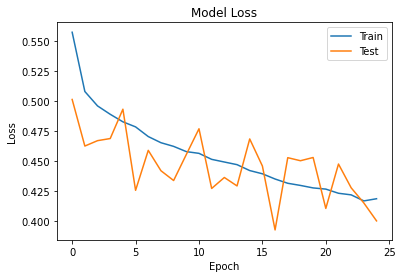

In [8]:
# Plot train and test loss by epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

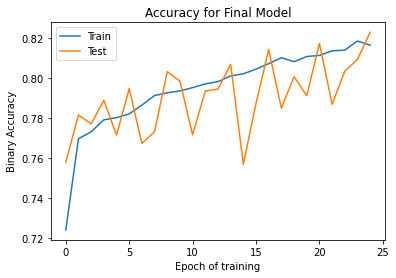

In [15]:
# Visualize the training

# Accuracy
plt.figure()
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.xlabel('Epoch of training')
plt.ylabel('Binary Accuracy')
plt.legend(['Train', 'Test'])
plt.title('Accuracy for Final Model')
plt.show()

# Evaluating the Model

Comparing the accuracy score of train and test sets.

In [10]:
# Get the accuracy of train set
train_accuracy = history.history["binary_accuracy"][-1]
print(f"Train Accuracy: {train_accuracy:.4f}")

# Evaluate with test set
result = model.evaluate(X_test,y_test, verbose=0)
print(f"Test Accuracy: {result[1]:.4f}") 

Train Accuracy: 0.8166
Test Accuracy: 0.8230


The train and test accuracies were 81.6% and 82.3%, respectively.
<br>
Below, the confusion matrix for the final Neural Network model is presented.

In [11]:
# Get the prediction value
y_pred = model.predict(X_test).round().astype(int)

In [12]:
# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Negative", "Predicted Positive"],
    index=["True Negative", "True Positive"]
)

display(cf_df)

,Predicted Negative,Predicted Positive
True Negative,5841,1084
True Positive,273,470


Let's check the other metrics and see how the Neural Network compares to the other models.

In [13]:
#Predict values based on new parameters
y_pred = model.predict(X_test).round().astype(int)

# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('ROC AUC Score : ' + str(roc_auc_score(y_test,y_pred)))

Accuracy Score : 0.8230307772561294
Precision Score : 0.30244530244530243
Recall Score : 0.6325706594885598
F1 Score : 0.40922942969090115
ROC AUC Score : 0.7380181817298395


| Model | Validation Accuracy |Test Accuracy| Test Precision |Test Recall| Test F1 |Test ROC AUC |
| ----- | ------------------- |------------ | ------------------- |------------- | ------- |------------ |
| Logistic Regression | 75.6% | 77.6% | 26.4% | 73.5% | 38.8% | 75.8% 
| KNN| 72.7% | 76.3% | 23.1% | 62.0% | 33.6% | 70%
| SVM| 75.2% | 77.5% | 25.5% | 68.8% | 37.2% | 73.6%
| Decision Tree| 75.4% | 68.9% | 20.6% | 77.6% | 32.6% | 72.8%
| Random Forest| 76.3% | 73.1% | 22.8% | 74.3% | 34.9% | 73.7%
| XGBoost| 76.5% | 75.3% | 24.5% | 74.7% | 36.9% | 75.0%
| Neural Network | 81.6% | 82.3% | 30.2% | 63.2% | 40.9% | 73.8%  

The table above compares the Neural Network with the classification models from Part 2. We can see that the test accuracy was significantly improved by the Neural Network (82.3%) compared to the other models. This means we can correctly predict the outcome of a bird strike 82.3% of the time.
However, similarly to what happened with the Decision Tree, this gain in accuracy was counterbalanced by a loss in the recall. In fact, the test recall of the neural network was only higher than the KNN model.

# Conclusion

In conclusion, the Neural Network had the highest accuracy in predicting the outcome of bird strikes compared to the other models, and it could be used for prediction and warning systems for pilots and other operators if prioritizing this metric. If recall is preferred as a score, then the decision tree model is recommended. On the other hand, XGBoost is suggested for a model balanced between recall and accuracy.
<br>
<br>
As discussed before, the learning gain between these models seems to be limited, with gains in accuracy being counter-balanced by loss in recall, and vice versa. Thus, it is suggested to include other explanatory features that may be missing from the present dataset. Such features could improve the predictive power of the models and, consequently, increase both accuracy and recall. Examples of additional features are the speed of the aircraft, the angle of the aircraft in relation to the soil and the bird at the moment of the strike, as well as conditions of the aircraft such as age and miles/years in service.

# References

[1] DeepAI. Neural Network. https://deepai.org/machine-learning-glossary-and-terms/neural-network. Accessed on September 22, 2021.
<br>
[2] IBM. What are Neural Networks. https://www.ibm.com/cloud/learn/neural-networks. Accessed on September 22, 2021.